### MNIST digit and a Random Number Addition NN using Pytorch
Assignment:

Write a neural network that can:

take 2 inputs:
- an image from MNIST dataset, and
- a random number between 0 and 9

and gives two outputs:
- the "number" that was represented by the MNIST image, and
- the "sum" of this number with the random number that was generated and sent as the input to the network  


Importing supporting libraries


In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader
import random
import matplotlib.pyplot as plt
% matplotlib inline
import numpy as np

Loading MNIST Dataset, which contains 28x28 px, 70,000 grayscale images of handwritten digits.


In [42]:
# We normalize both train and test dataset with the mean and std of the train dataset.
# Training data transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # Mean and Std Dev are used in tuples  
                                       ])

# Testing data transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Download and apply tranforms on the MNIST dataset using torchvision.datasets
train_dataset = torchvision.datasets.MNIST('/tmp', train=True, download=True, transform=train_transforms)
test_dataset = torchvision.datasets.MNIST('/tmp', train=False, download=True, transform=test_transforms)

Creating Custom dataset with MNIST dataset and Random Number


In [43]:
# Defining a Sequence for custom dataset
class CustomMNISTDataset(Dataset):
  def __init__(self, dataset):
    self.dataset = dataset
    #creating unique tensor representation for each digit
    self.one_hot_encoding = torch.nn.functional.one_hot(torch.arange(0, 10))

  def __getitem__(self, idx):
    random_number = random.randint(0,9)
    mnist_label = self.dataset[idx][1]
  
    #add actual mnist label and a random number to have ground truth sum
    sum = mnist_label + random_number
    return self.dataset[idx][0], mnist_label, self.one_hot_encoding[random_number], sum

  def __len__(self):
    return len(self.dataset)

In [44]:
# Initializing custom datasets sequences
train_custom_dataset = CustomMNISTDataset(train_dataset)
test_custom_dataset = CustomMNISTDataset(test_dataset)

In [45]:
# Initialising Data Loader to get custom data in batches
train_loader = DataLoader(train_custom_dataset,batch_size=256,shuffle=True)
test_loader = DataLoader(test_custom_dataset,batch_size=256)

Dataset Info




In [46]:
# Iterating to get first batch
data_iter = iter(train_loader)
images, labels, rnd_num, sums = data_iter.next()

print('Batch Images: ', images.shape)
print('Batch Labels: ', labels.shape)
print('Batch Random Numbers: ', rnd_num.shape)
print('Batch Sums: ', sums.shape)

Batch Images:  torch.Size([256, 1, 28, 28])
Batch Labels:  torch.Size([256])
Batch Random Numbers:  torch.Size([256, 10])
Batch Sums:  torch.Size([256])


Defining the Model

In [47]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #Input: 28*28*1
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        #Input: 28*28*32      
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        #Input: 28*28*64        
        self.pool1 = nn.MaxPool2d(2, 2)     
        #Input: 14*14*64              
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        #Input: 14*14*128        
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        #Input: 14*14*256  
        self.pool2 = nn.MaxPool2d(2, 2)   
        #Input: 7*7*256                  
        self.conv5 = nn.Conv2d(256, 256, 3)   
        #Input: 5*5*256             
        self.conv6 = nn.Conv2d(256, 512, 3) 
        #Input: 3*3*512                  
        self.conv7 = nn.Conv2d(512, 10, 3)  

        #Input: 1 * 1 * 10
        #Merging MNIST model output with random number to train on custom data
        self.fc1 = nn.Linear(10+10, 128)       
        self.fc2 = nn.Linear(128, 19) # Sum output classes can be [0-18]

    def forward(self, input, number):
        # Acts as first convolution block
        x = F.relu(self.conv2(F.relu(self.conv1(input))))
        # Acts as first transition block
        x = self.pool1(x)
        # Acts as second convolution block
        x = F.relu(self.conv4(F.relu(self.conv3(x))))
        # Acts as second convolution block
        x = self.pool2(x)
        # Acts as third convolution block
        x = F.relu(self.conv6(F.relu(self.conv5(x))))
        # Acts as output convolution block
        x = self.conv7(x)  
        # Flatten the MNIST output 
        x = x.view(-1, 10)
        # Concatenate number input to the MNIST output
        x1 = torch.cat((x, number), dim=1)
        # Fully connected Layer to train on combined data
        x1 = F.relu(self.fc1(x1))  
        x1 = self.fc2(x1)  

        # return probability like predictions using softmax for both MNIST and combined data
        return F.log_softmax(x, dim=1), F.log_softmax(x1, dim=1)

Loading Model

In [48]:
# Loading model to the GPU device
device = torch.device("cuda")
model = Net().to(device)
model.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (conv7): Conv2d(512, 10, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=19, bias=True)
)

Training Loop

In [50]:
def train(model, device, train_loader, optimizer, epoch):
    # training model
    model.train()
    # initialising loss
    epoch_loss = 0
    correct_digit_pred_count = 0
    correct_sum_pred_count = 0

    # iterate dateset in batch using train_loader
    for batch_idx, (img, label, random_number, sum) in enumerate(train_loader):

        # fetch the ground truth data
        gt_label = label.type(torch.LongTensor)
        gt_sum = sum.type(torch.LongTensor)

        # move gt data to GPU
        img, gt_label, gt_sum = img.to(device), gt_label.to(device), gt_sum.to(device)
        # zero out the gradients
        optimizer.zero_grad()

        # forward pass
        output, sum_output = model(img,random_number.to(device))

        # compute the loss occured
        mnist_loss = F.nll_loss(output, gt_label)
        addition_loss = F.nll_loss(sum_output, gt_sum)
        loss= (mnist_loss + addition_loss)/2

        epoch_loss += loss.item()

        # compute the backward gradients
        loss.backward()

        # update the optimizer params
        optimizer.step()

        # get prediction output based on maximum softmax out
        digit_pred = output.argmax(dim=1, keepdim=True)
        sum_pred = sum_output.argmax(dim=1, keepdim=True)

        correct_digit_pred_count += digit_pred.eq(gt_label.view_as(digit_pred)).sum().item()
        correct_sum_pred_count += sum_pred.eq(gt_sum.view_as(sum_pred)).sum().item()

    print(f'Train set: Average loss: {loss.item():.4f}, Total MNIST Correct: {correct_digit_pred_count}, Total Sum correct: {correct_sum_pred_count}')

    train_loss = epoch_loss / len(train_loader)
    return train_loss



Testing Loop

In [51]:
def test(model, device, test_loader):
    # evaluation model
    model.eval()
    # initialising test loss
    test_loss = 0
    correct_digit_pred_count = 0
    correct_sum_pred_count = 0

    # stop gradients flow
    with torch.no_grad():
        for (img, label, random_number, sum) in test_loader:
            gt_label = label.type(torch.LongTensor)
            gt_sum = sum.type(torch.LongTensor)
            img, gt_label, gt_sum = img.to(device), gt_label.to(device), gt_sum.to(device)

            # forward pass
            output, sum_output = model(img,random_number.to(device))
            # average loss of both outputs
            test_loss += (F.nll_loss(output, gt_label, reduction='sum').item() + F.nll_loss(sum_output, gt_sum, reduction='sum').item())/2

            # get prediction output based on maximum softmax out
            digit_pred = output.argmax(dim=1, keepdim=True)
            sum_pred = sum_output.argmax(dim=1, keepdim=True)

            correct_digit_pred_count += digit_pred.eq(gt_label.view_as(digit_pred)).sum().item()
            correct_sum_pred_count += sum_pred.eq(gt_sum.view_as(sum_pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print(f'Test set: Average loss: {test_loss:.3f}, Digit Accuracy:{100. * correct_digit_pred_count/len(test_loader.dataset)}, Sum Accuracy:{100. * correct_sum_pred_count/len(test_loader.dataset)}')
    return test_loss


Train and Test the model

In [52]:
#Loading model to GPU
model = Net().to(device)
# using Stochastic Gradient Descent as the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

num_epoch = 10
train_losses = []

# Epoch loop
for epoch in range(1, num_epoch+1):
    print('\nEpoch {} : '.format(epoch))
    # train the model
    train_loss = train(model, device, train_loader, optimizer, epoch)
    train_losses.append(train_loss)



Epoch 1 : 
Train set: Average loss: 1.3325, Total MNIST Correct: 39040, Total Sum correct: 6212

Epoch 2 : 
Train set: Average loss: 1.1670, Total MNIST Correct: 57675, Total Sum correct: 9732

Epoch 3 : 
Train set: Average loss: 1.1285, Total MNIST Correct: 58730, Total Sum correct: 15928

Epoch 4 : 
Train set: Average loss: 0.9991, Total MNIST Correct: 59090, Total Sum correct: 24950

Epoch 5 : 
Train set: Average loss: 0.8109, Total MNIST Correct: 59286, Total Sum correct: 35291

Epoch 6 : 
Train set: Average loss: 0.7275, Total MNIST Correct: 59414, Total Sum correct: 45081

Epoch 7 : 
Train set: Average loss: 0.5712, Total MNIST Correct: 59489, Total Sum correct: 53196

Epoch 8 : 
Train set: Average loss: 0.4247, Total MNIST Correct: 59581, Total Sum correct: 57117

Epoch 9 : 
Train set: Average loss: 0.3327, Total MNIST Correct: 59647, Total Sum correct: 58794

Epoch 10 : 
Train set: Average loss: 0.1851, Total MNIST Correct: 59709, Total Sum correct: 59371


In [53]:
#Evaluation on testing data
test_loss = test(model, device, test_loader)

Test set: Average loss: 0.210, Digit Accuracy:99.23, Sum Accuracy:98.88


No handles with labels found to put in legend.


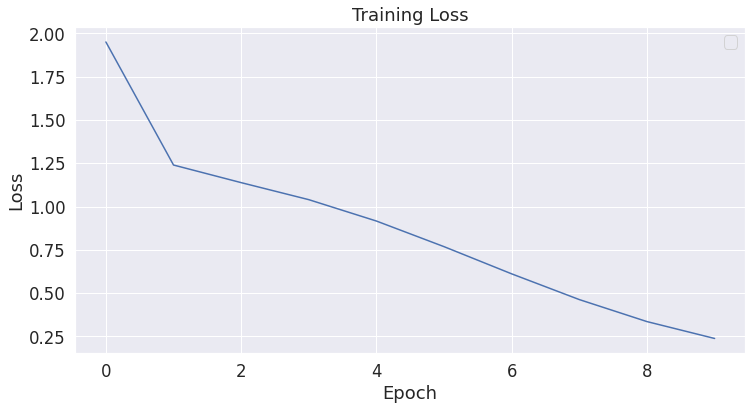

In [54]:
# Plotting loss curve
plt.rcParams["figure.figsize"] = (12,6)
plt.plot(np.array(train_losses))
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

Inference

In [74]:
test_image, test_label,_,_ = test_custom_dataset[434]
test_number = random.randint(0,9)
ohe = torch.nn.functional.one_hot(torch.arange(0, 10))
# Model inference
mnist_out, sum_out = model(test_image.unsqueeze(dim=1).to(device),ohe[test_number].reshape(-1,10).to(device))
mnist_pred = mnist_out.argmax(dim=1, keepdim=True)
sum_pred = sum_out.argmax(dim=1, keepdim=True)
print(f'Random Number : {test_number}')
print(f'MNIST Actual: {test_label}')
print(f'MNIST Prediction: {mnist_pred.item()}')
print(f'Sum: {test_number} + {mnist_pred.item()}')
print(f'Sum Prediction = {sum_pred.item()}')

Random Number : 8
MNIST Actual: 9
MNIST Prediction: 9
Sum: 8 + 9
Sum Prediction = 17
